# Overview & Assumptions

__Assumptions__

1. Features will be selected if they are realistically available at inference time.
2. Zipcode, DoB and Gender have high proportions of missing values and are only available if members input their data (subject to preference). Given the high missing proportion, we assume these will not always be available at inference time and are dropped.
3. Weather data from sensors will be available at inference time for the app. Even though the weather data is 4 months short of the trips data (weather data ends July 2013 but trips data is till November 2013). Despite this, given this assumption, it is justified to include weather data despite the missing 4 months (Edit - unfortunately, rides from municipals other than Boston like Sommerville only exist in the last 4 months, so dropping the last 4 months would remove data from other municipals. so we will not use weather).

__Approaches__

We will focus on predicting the destination (ending station). There are two main approaches.

1. One Large Model Approach - Firstly, we could train a model on the entire dataset and use it to predict the destination.
2. Individual Model Approach - Secondly, we could train a model for each station/user separately, then at inference time, reference the model corresponding to that station to predict. This way, each station will have it's own unique history and dataset.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier, XGBRegressor
import vaex.ml
import vaex
from vaex.ml.catboost import CatBoostModel
from catboost import CatBoostClassifier

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.combine import SMOTEENN

In [2]:

trips_date_parser = lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S")
weather_date_parser = lambda x: datetime.strptime(x, "%Y%m%d %H:%M")

trips = pd.read_csv(f'data\hubway_trips.csv', 
                    index_col='start_date', 
                    parse_dates=True, 
                    date_parser=trips_date_parser,
                    infer_datetime_format=True)

weather = pd.read_csv(f'data\weather.csv', 
                      index_col='DATE', 
                      parse_dates=True, 
                      date_parser=weather_date_parser,
                      infer_datetime_format=True)

stations = pd.read_csv(f'data\hubway_stations.csv')

In [3]:
trips.nunique()

seq_id        1579025
hubway_id     1579025
status              1
duration        15635
strt_statn        142
end_date       515102
end_statn         142
bike_nr          1163
subsc_type          2
zip_code          530
birth_date         60
gender              2
dtype: int64

In [4]:
trips.isna().sum()

seq_id              0
hubway_id           0
status              0
duration            0
strt_statn         14
end_date            0
end_statn          45
bike_nr           466
subsc_type          0
zip_code       472766
birth_date    1228381
gender         472611
dtype: int64

In [5]:
stations.nunique()

id           142
terminal     131
station      137
municipal      4
lat          142
lng          142
status         2
dtype: int64

In [6]:
weather.nunique()

STATION              1
STATION_NAME         1
ELEVATION            1
LATITUDE             1
LONGITUDE            1
HPCP                51
Measurement_Flag     3
Quality_Flag         1
dtype: int64

In [7]:
trips.describe().round(0)

,seq_id,hubway_id,duration,strt_statn,end_statn,birth_date
count,1579025.0,1579025.0,1579025.0,1579011.0,1578980.0,350644.0
mean,789513.0,886532.0,1200.0,54.0,54.0,1976.0
std,455825.0,506478.0,26535.0,34.0,33.0,11.0
min,1.0,8.0,-6900.0,3.0,3.0,1932.0
25%,394757.0,446525.0,412.0,27.0,29.0,1969.0
50%,789513.0,895044.0,660.0,48.0,48.0,1979.0
75%,1184269.0,1328083.0,1082.0,74.0,74.0,1985.0
max,1579025.0,1748022.0,11994458.0,145.0,145.0,1995.0


# Investigating Data: Insights

__Trips__

* Sequence ID - Integer. Unique record ID. 
* Hubway ID - Integer. 
* Status - Trip status. All trips are closed, not very useful.
* Duration - The duration of the trip, in seconds.
* Start Date/End Date - Date and time (Jul 2011 - Nov 2013). Use to create seasonal features, e.g season, month, day of week, weekend, peak hour/offpeak hour, etc.
* Start/End Station - Integer ID which maps to `stations`. There are 142 unique stations. 
* Bike Number - Alphanumeric. 1163 unique values.
* Subscriber Type - Binary.
* Zip Code - Zip code of the user that rode the bike. 1/3 (~500k/1.5m) missing.
* Birth Date - 4/5 missing. Don't use. Would be nice to compute an age feature (old men take longer) but if 80% data is missing, no point.
* Gender - 1/3 missing.

__Stations__

* ID - Added by MAPC which corresponds to station lat and long.
* Terminal - Hubway ID, original ID changes if stations relocate, so MAPC added ID
* Station - The station name. A string. Can use ID.
* Municipal - 4 municipals (Boston, Cambridge, Brookline, Somerville).
* Status - 130 existing, 12 removed. 

__Weather__

* Date - This is daily from the data collection period (Jul 2011 - Jul 2013) with hourly reporting. Refers to the weather statistic in the previous hour. E.g data point at 1pm was the precipitation from 12pm-1pm.
* HPCP - Amount of rainfall for the past hour





# Data Preprocessing 

First, we'll drop columns we don't need. 

__Trips__

* `seq_id`, `hubway_id` are unique identifiers.
* `end_date` is redundant.
* `bike_nr` is redundant because there are 1000 bikes.
* `zip_code`, `gender` and `birth_date` are useful but they are 1/3, 1/3 and 4/5s missing respectively. Thus, imputing is not possible, leaving dropping empty values the only option.

__Stations__

* Only one of `ID`, `terminal` and `station` is needed.
* `Status` if this is removed, then no need to include it in the dataset.

__Weather__

* `STATION, STATION_NAME, ELEVATION, LATITUDE, LONGITUDE` are the same.
* `Quality_Flag` is empty.	


In [8]:
def preprocess_data(trips, stations, weather, include_weather=True):

    # select desired columns based on assumptions - drop stations with empty values
    trips_ = trips[['subsc_type', 'strt_statn', 'end_statn', 'duration', 'zip_code']].dropna(subset=['strt_statn', 'end_statn','zip_code'])
    stations_ = stations[['id', 'municipal', 'lat', 'lng', 'status']]
    weather_ = weather[['HPCP']]

    # merge trips and stations so we can drop rows with removed stations
    df = pd.merge(left=stations_, right=trips_, left_on='id', right_on='strt_statn')\
            .drop(columns=['id'])\
            .set_index(trips_.index)
    df = df[df.status == 'Existing']\
            .drop(columns=['status'])
        
    # convert zipcode to int if zipcode is used
    df.zip_code = (df.zip_code.str.slice(start=1)).astype(int)
     
    # round the index to hourly
    df.index = df.index.round('H')

    # get rid of negative duration trips
    df = df[df.duration > 0] 

    # cast stations to int
    df.strt_statn = df.strt_statn.astype(int)
    df.end_statn = df.end_statn.astype(int) 

    # if we want to use precipitation as a feature, backfill HPCP based on last obs, then drop the last 4 months (~1/3 of rows). Unless we use an updated weather data source
    if include_weather:
        df = df.join(weather_).fillna(method='bfill').dropna(subset=['HPCP'])

    # datetime features
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek + 1
    df['is_rushhour'] = (df.index.hour.isin([7, 8, 9, 17, 18])).astype(int) 
    df['is_weekend'] = (df.index.dayofweek > 4).astype(int)

    # seasonal features    
    # https://stackoverflow.com/questions/44124436/python-datetime-to-season
    # https://www.boston-discovery-guide.com/boston-weather-seasons.html  
    # 4 = Winter, 1 = Summer, 2 = Spring, 3 = Fall
    seasons = [4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4] 
    month_to_season = dict(zip(range(1,13), seasons))
    df['season'] = df.index.month.map(month_to_season)
 
    print(df.columns)
    return df

In [9]:
df = preprocess_data(trips, stations, weather, False)
df.to_pickle('data\df')

Index(['municipal', 'lat', 'lng', 'subsc_type', 'strt_statn', 'end_statn',
       'duration', 'zip_code', 'hour', 'month', 'dayofweek', 'is_rushhour',
       'is_weekend', 'season'],
      dtype='object')


# EDA

* Histograms/Boxplots of continuous features and label - Understand distribution, look for outliers/extreme skew.(DONE)
* Barcharts of categorical features and label - Check for imbalance, etc (DONE)
* GIS charts with lat and long - think of something (TODO - e.g plot stations on a map).

In [10]:
df = pd.read_pickle('data\df')

We can see the distribution of number of starting rides by station - the most popular start points.


<AxesSubplot: xlabel='strt_statn'>

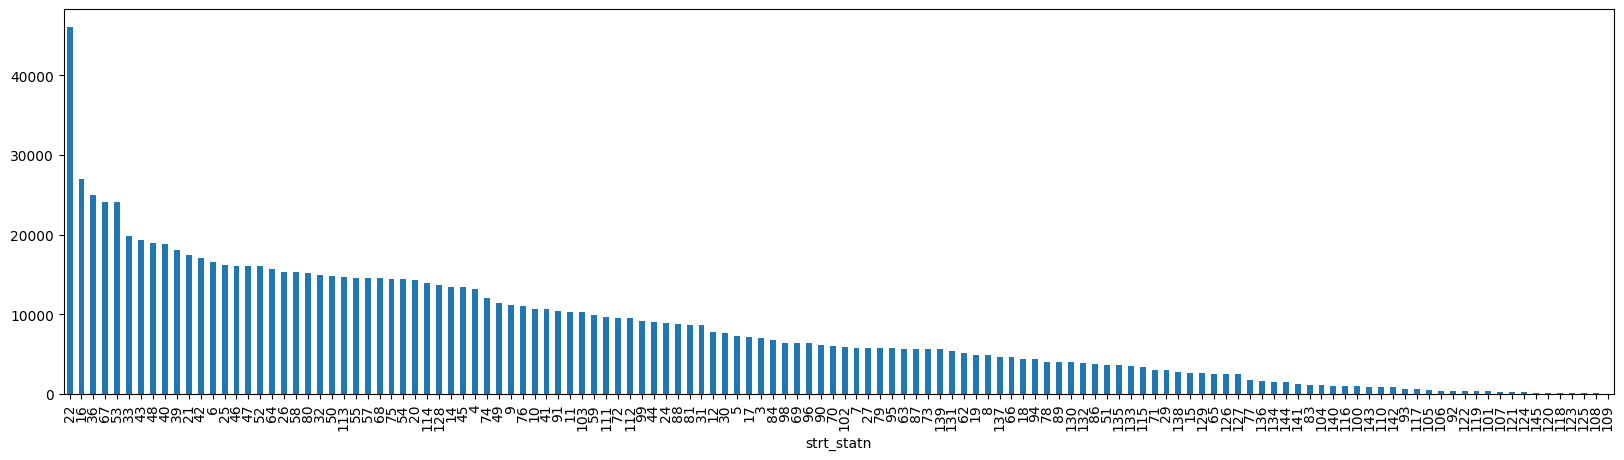

In [11]:
stns_by_rides = df.groupby('strt_statn')['end_statn'].count().sort_values(ascending=False)
fig,ax = plt.subplots(figsize=(20,5))
stns_by_rides.plot(kind='bar')

<AxesSubplot: xlabel='end_statn'>

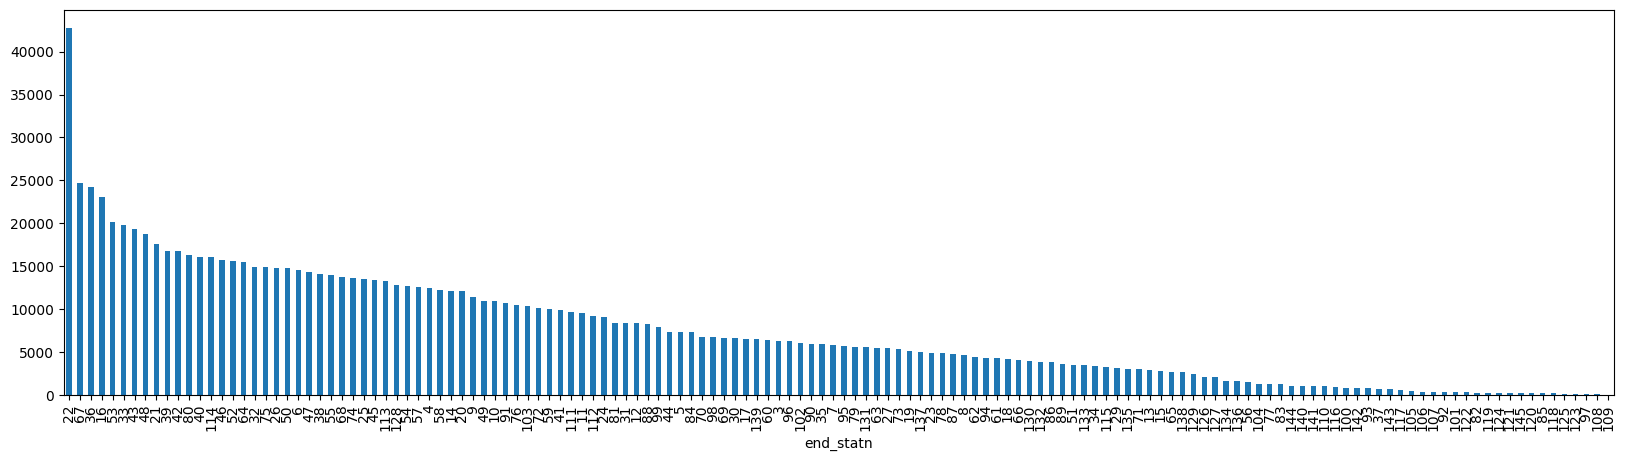

In [12]:
stns_by_end = df.groupby('end_statn')['strt_statn'].count().sort_values(ascending=False)
fig,ax = plt.subplots(figsize=(20,5))
stns_by_end.plot(kind='bar')

In [13]:
zipcodes = df.groupby('zip_code')['strt_statn'].count().sort_values(ascending=False)

zipcodes.describe()

count       528.000000
mean       1987.477273
std        9220.998031
min           1.000000
25%          23.000000
50%         104.500000
75%         515.750000
max      117147.000000
Name: strt_statn, dtype: float64

We can see that the median zipcode has 104 rides. Thus, most rides are concentrated around a few zipcodes.

Majority of the stations are in Boston.

<AxesSubplot: >

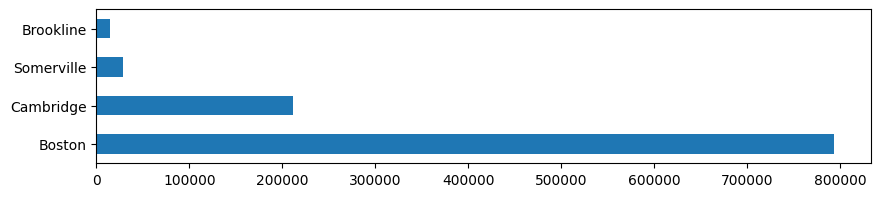

In [14]:
plt.figure(figsize=(10,2))
df.municipal.value_counts().plot(kind='barh')


Faceting the stations by municipal, we see the distribution of ending stations given a starting municipal is quite different. Note that if we join based on weather (HPCP) data, then the last 4 months of data are missed out (no reading for those dates). This also removes datapoints from Cambridge/Brookline/Somerville which were recorded in the last 4 months. Hence, I decided not to use weather as a feature (for now).

<AxesSubplot: xlabel='duration'>

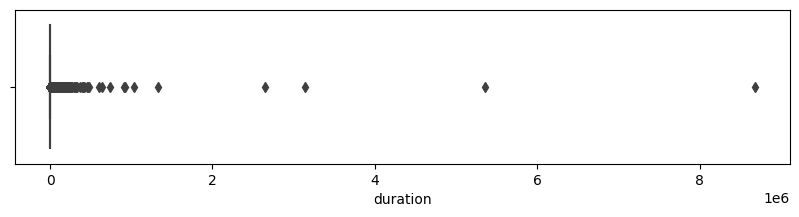

In [16]:
plt.figure(figsize=(10,2))
sns.boxplot(df, x='duration')

Given this boxplot, it makes sense to do some winsorization on the upper end (clip upper extreme values). This replaces the values beyond a certain percentile with the percentile limit itself without dropping them.

In [17]:
clipped_duration = df.duration.clip(lower=df.duration.quantile(0.005), upper=df.duration.quantile(0.98))

We can see after clipping, the values look more reasonable. The spike at 80 minutes is due to the winsorization.

<AxesSubplot: ylabel='Frequency'>

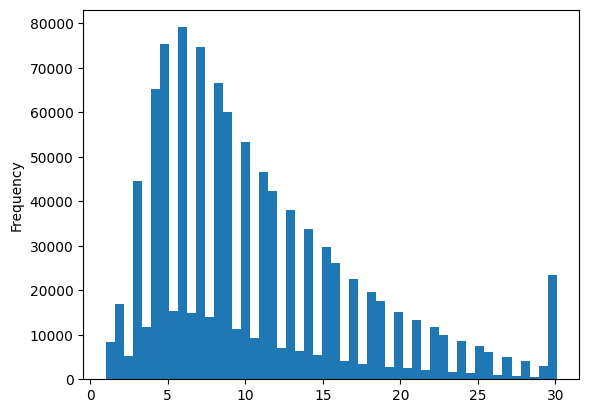

In [18]:
(clipped_duration/60).plot(kind='hist', bins=50)

However, since we are not predicting duration, we don't need the duration label.

# Modelling

In [19]:
def split(df):

    # drop lat and long
    df = df.drop(labels=['lat', 'lng', 'duration'], axis=1)

    # train-test split
    df_train, df_test = train_test_split(df, test_size=0.30, shuffle=True, stratify=df.end_statn, random_state=42)

    return df_train, df_test

def evaluate_classifier(y_true, y_preds):
    
    acc = accuracy_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds, average='weighted')
    cm = confusion_matrix(y_true, y_preds)


    labels = np.arange(0,np.unique(y_true).shape[0])
    annot_cm = pd.DataFrame(cm, index=labels, columns=labels)

    print(f'accuracy: {acc.round(4)}')
    print(f'f1 score: {f1.round(4)}')

    plt.figure(figsize = (15,15))
    sns.heatmap(annot_cm)
    plt.show()

    return acc, f1

## One Large Model Approach

The idea for this approach is to train one large model on the entire dataset. However, the performance metrics shows it performs quite badly.

### Feature Engineering

In [20]:
def vaex_fe(df_train, df_test):
    
    # conversion to Vaex dataframes
    vaex_cat = ['municipal', 'subsc_type', 'strt_statn', 'end_statn','zip_code']
    cycle_cat = ['hour', 'month', 'dayofweek', 'season']
    
    def prep_vaex(df):    
        df = vaex.from_pandas(df=df)
        le = vaex.ml.LabelEncoder(features=vaex_cat)
        df = le.fit_transform(df)        
        df = df.drop(columns=vaex_cat)

        return df
    
    df_train = prep_vaex(df_train)
    df_test = prep_vaex(df_test)

    return df_train, df_test

In [21]:
_df_train, _df_test = split(df)
_df_train, _df_test = vaex_fe(_df_train, _df_test)


### Model Training & Evaluation 

To evaluate, we can use accuracy as a proxy (number of classes correct/number of predictions) and the weighted F1 score (for imbalanced multiclass problems).

In [22]:
def train_vaex_catboost(train, test):

    features = ['hour', 'month', 'dayofweek', 'is_rushhour', 'is_weekend', 'season', 'label_encoded_municipal', 'label_encoded_subsc_type', 'label_encoded_strt_statn', 'label_encoded_zip_code']
    target = 'label_encoded_end_statn'

    params = { 'leaf_estimation_method': 'Gradient',
               'objective': 'MultiClass',
               'random_state': 42
             }

    booster = CatBoostModel(features=features, target=target, num_boost_round=10, params=params, prediction_type='Class')
    booster.fit(train, progress='widget')
    res = booster.transform(test)

    y_true = test.label_encoded_end_statn.to_numpy()    
    y_preds = res[:,-1].to_numpy()    

    return y_true, y_preds


In [23]:
_y_true, _y_preds = train_vaex_catboost(_df_train, _df_test)

0:	learn: 4.9553434	total: 8.18s	remaining: 1m 13s
1:	learn: 4.9548216	total: 14.5s	remaining: 57.9s
2:	learn: 4.9543033	total: 20.7s	remaining: 48.2s
3:	learn: 4.9538063	total: 26.9s	remaining: 40.3s
4:	learn: 4.9533110	total: 33.1s	remaining: 33.1s
5:	learn: 4.9528616	total: 39.6s	remaining: 26.4s
6:	learn: 4.9523604	total: 45.9s	remaining: 19.6s
7:	learn: 4.9518665	total: 52s	remaining: 13s
8:	learn: 4.9513562	total: 58.3s	remaining: 6.48s
9:	learn: 4.9508584	total: 1m 4s	remaining: 0us


accuracy: 0.0207
f1 score: 0.01


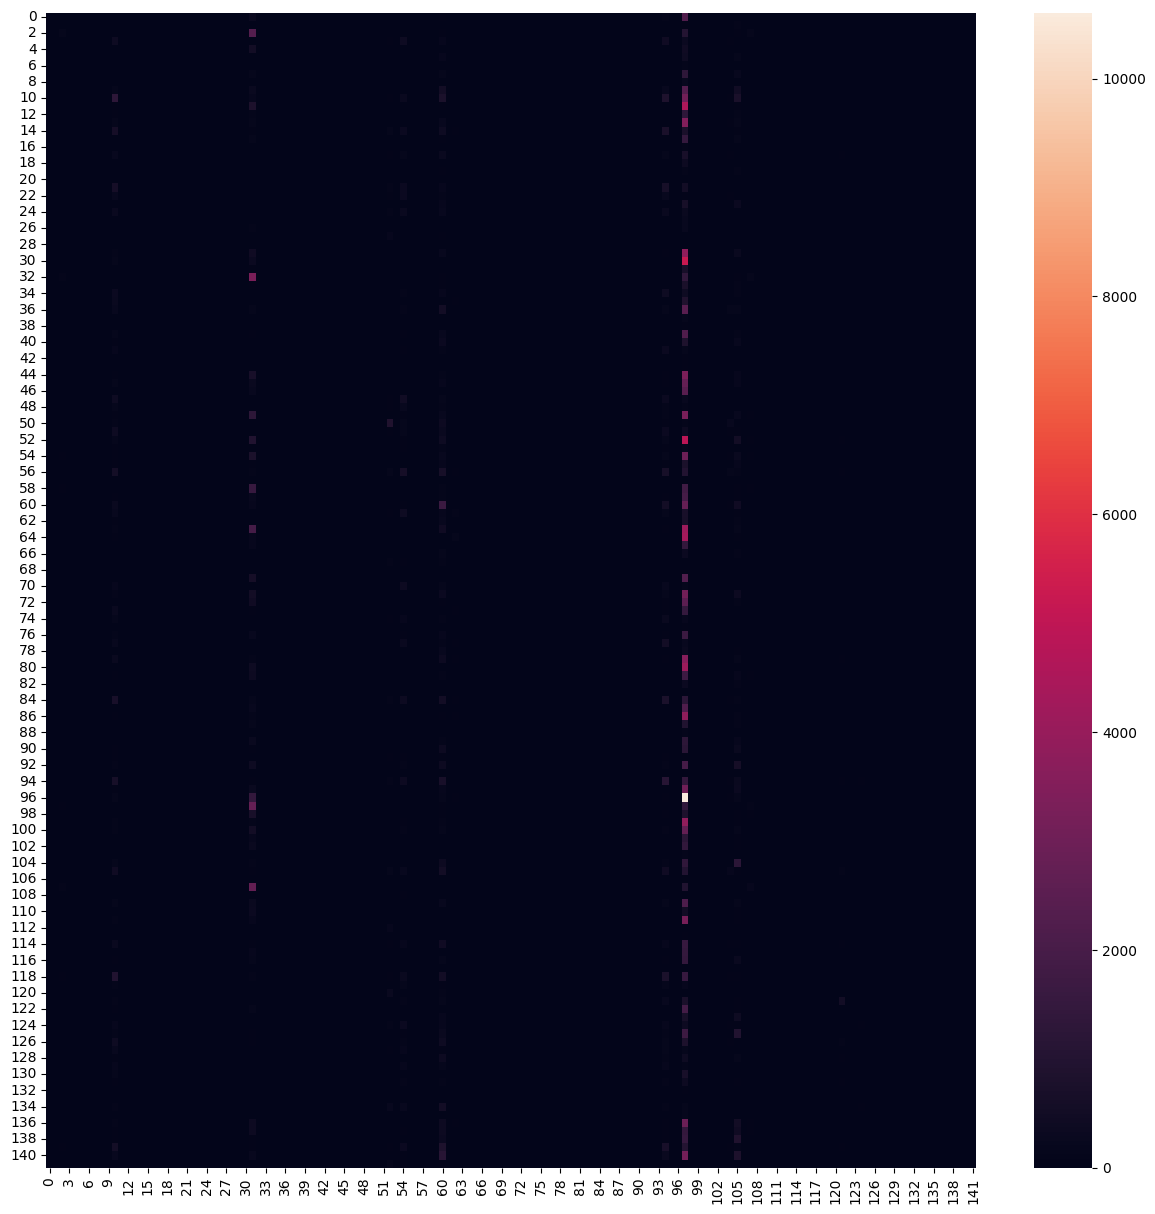

In [24]:

_acc, _f1 = evaluate_classifier(_y_true, _y_preds)

Unfortunately, the approach of one single model does not yield good results. Naively, we would expect a random guess to be right 1/142 times (assuming each station has equal probability of being a destination), which is `~0.007`. The model has an accuracy of `0.0214` which is 3 times better than a random guess.

We can also see that the imbalance has caused the model to predict the majority station quite often.


## Individual Model Approach - Per Station or User.

The idea for this approach is to split the models by station or user, based on the hypothesis that each station will have it's own unique ridership pattern, or each user has his own ridership patterns. Splitting by station, we can cover all the data points, but if we split by user (zipcode), then new users will not be able to have a prediction until they have sufficient ride history. Since new users come along more frequently than new stations, stations is the more practical approach.

With this approach, we can use native boosting libraries without any memory issues. In theory, this lets us overcome the imbalance issue.

However, we can only use this method on stations with sufficient sample size. In this case, if a station has less than 2000 rides, I will not include it.



### Model Training & Evaluation


In [25]:


def train_single_model(df):
    
    X, y = df[df.columns.difference(['end_statn', 'duration'])], df['end_statn']
    
    cat_features = list(range(X.shape[1]))

    if X.shape[0] <= 10000:
        iterations = 8
    else:
        iterations = min(15,int(X.shape[0]/1000))

    params = {
              'loss_function':'MultiClass',
              'cat_features': cat_features,
              'one_hot_max_size': 15,
              'task_type': 'GPU',
              'iterations': iterations,
              'devices': '0',
              'verbose': 0
            }
    
    clf = CatBoostClassifier(**params)

    clf.fit(X,y)
    print(f'iterations for station number {df.name} with {X.shape[0]} rows: {iterations} iterations.')

    return clf

def predict_indiv_station(df, models):
    
    # lookup model from series
    clf = models[df.name]
    X = df[df.columns.difference(['end_statn', 'duration'])]
    
    # predict
    labels = clf.predict(X)
    return labels


def train_all_models(df_train, df_test):

    model_list = df_train.groupby('strt_statn').apply(train_single_model)
    labels = df_test.groupby('strt_statn').apply(predict_indiv_station, models=model_list)
    
    y_true = df_test.end_statn.to_numpy()    
    y_preds = labels.to_numpy().flatten()

    return y_true, y_preds
    


In [26]:
filter_statns = stns_by_rides[stns_by_rides < 2000].index.values
df = df[~df.strt_statn.isin(filter_statns)]

df_train, df_test = split(df)
y_true, y_preds = train_all_models(df_train, df_test)

iterations for station number 3 with 4923 rows: 8 iterations.
iterations for station number 4 with 9153 rows: 8 iterations.
iterations for station number 5 with 5158 rows: 8 iterations.
iterations for station number 6 with 11585 rows: 11 iterations.
iterations for station number 7 with 4099 rows: 8 iterations.
iterations for station number 8 with 3417 rows: 8 iterations.
iterations for station number 9 with 7823 rows: 8 iterations.
iterations for station number 10 with 7573 rows: 8 iterations.
iterations for station number 11 with 7218 rows: 8 iterations.
iterations for station number 12 with 5546 rows: 8 iterations.
iterations for station number 14 with 9509 rows: 8 iterations.
iterations for station number 15 with 1860 rows: 8 iterations.
iterations for station number 16 with 18920 rows: 15 iterations.
iterations for station number 17 with 5063 rows: 8 iterations.
iterations for station number 18 with 3094 rows: 8 iterations.
iterations for station number 19 with 3374 rows: 8 iterati

accuracy: 0.0155
f1 score: 0.0132


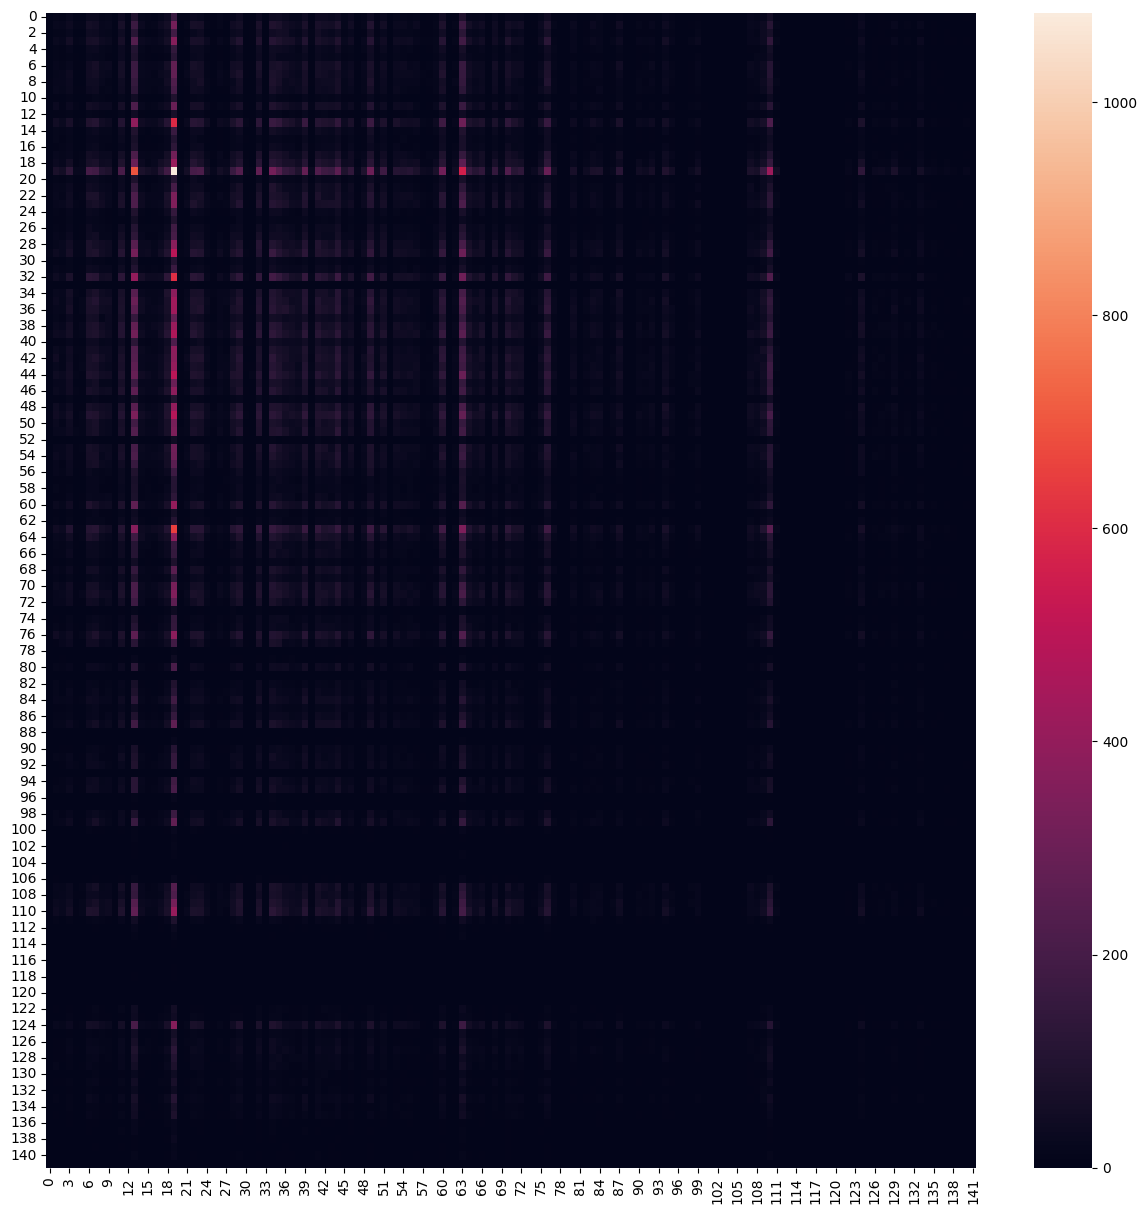

In [27]:

acc, f1 = evaluate_classifier(y_true, np.concatenate(y_preds).ravel())

# Review and Evaluation 

__Approaches Tried__

To conclude, it seems like given the available data and constraints, predicting the destination (end station) is difficult. It is likely the relationship between features and target is very weak/no-relationship. A users choice on which station to go could depend on many different factors not captured in the data. These are the things I have tried to do:

1. Use undersampling and oversampling - via `imblearn`. I do believe under/oversampling could improve performance, however I could have experimented more.
2. Toggle various categorical encoding options 
3. Toggle model parameters

__Other Practical Approaches__

In my opinion, the real-life approach that such a company would do is to make users sign up to use their app and consent to track their ride data, as well as to use some personal data. Then, they could cluster users together based on their ride characteristics and personal data, then train models for each of these clusters and use them to suggest the destination and duration for a particular user. This would be based on the notion that different users have different use patterns, and may repeat these patterns regularly (e.g taking the same ride from home to work). 

They could even avoid ML alternatively by just keeping track of ride history and showing 'your most common destinations' like the Grab app does. To illustrate, at a given start station, simply suggest the most frequent destination for that user from that station (from his/her past history).


__Things I Could Have Tried__

1. Join weather (HPCP) data based on seasonal features. This would let me extrapolate weather data for the last 4 months.
2. Experimented training models by zipcode. However, the zipcode distribution was similar to the starting station distribution in the sense it was extremely imbalanced.
3. Experimented with including more features (bike number) for example.
4. Plotted GIS charts with the lat and long data of starting stations overlayed on a Boston map. However, due to time constraints, I was unable to do so.
5. Fine-tuned performance with cross-validation and hyperparameter tuning.

__Model Choice__

`Catboost` was chosen because of performance and native support for categorical encoding. For the large model, `vaex` was chosen because working with such a large dataset can cause performance issues when memory is insufficient. `vaex` offers high performance and speed for large datasets.

